# 參數優化 - 將歷史報酬提升數倍的方式！

這個單元中，我們首先要來撰寫一個獲利的策略

寫一個策略，首先要來將我們之前爬到的數據拿出來

## 拿出歷史大盤數據

In [3]:
from finlab.data import Data

data = Data()
twii = data.get('發行量加權股價指數')
twii = twii[(twii.index.second == 0)]['台股指數']  # 頻率變成每分鐘一筆(認秒==0的位置)
twii.tail()

date
2019-09-06 13:26:00    10778.14
2019-09-06 13:27:00    10778.14
2019-09-06 13:28:00    10778.14
2019-09-06 13:29:00    10778.14
2019-09-06 13:30:00    10780.64
Name: 台股指數, dtype: float64

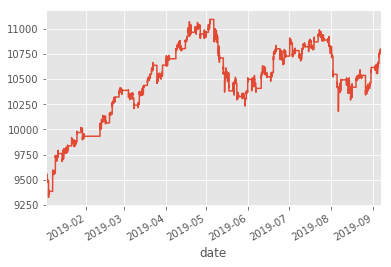

In [4]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

twii.plot()

## 分析乖離率

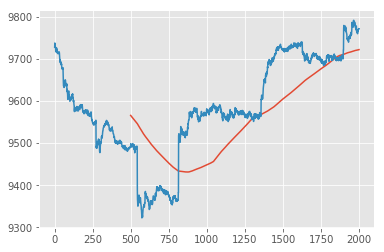

In [5]:
sma = twii.rolling(500).mean()  # 計算乖離率必須先算出均線
bias = twii / sma  # 乖離率 -> 股價 / 均線

plt.plot(sma.values[:2000])
plt.plot(twii.values[:2000])

### upper/ lower bound

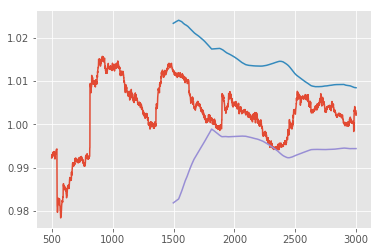

In [6]:
# 判斷乖離率太高or太低
ub = bias.rolling(1000).mean() + bias.rolling(1000).std() * 2
lb = bias.rolling(1000).mean() - bias.rolling(1000).std() * 2

plt.plot(bias.values[:3000])
plt.plot(ub.values[:3000])
plt.plot(lb.values[:3000])

# Bias(乖離率)過低的時候(股價在均線下)，頃向漲上來
# 反之乖離率正很多的時候，股價頃向下跌 -> 可利用這個特性製作策略

## 乖離率策略

date
2019-01-02 09:00:00    NaN
2019-01-02 09:01:00    NaN
2019-01-02 09:02:00    NaN
2019-01-02 09:03:00    NaN
2019-01-02 09:04:00    NaN
2019-01-02 09:05:00    NaN
2019-01-02 09:06:00    NaN
2019-01-02 09:07:00    NaN
2019-01-02 09:08:00    NaN
2019-01-02 09:09:00    NaN
2019-01-02 09:10:00    NaN
2019-01-02 09:11:00    NaN
2019-01-02 09:12:00    NaN
2019-01-02 09:13:00    NaN
2019-01-02 09:14:00    NaN
2019-01-02 09:15:00    NaN
2019-01-02 09:16:00    NaN
2019-01-02 09:17:00    NaN
2019-01-02 09:18:00    NaN
2019-01-02 09:19:00    NaN
2019-01-02 09:20:00    NaN
2019-01-02 09:21:00    NaN
2019-01-02 09:22:00    NaN
2019-01-02 09:23:00    NaN
2019-01-02 09:24:00    NaN
2019-01-02 09:25:00    NaN
2019-01-02 09:26:00    NaN
2019-01-02 09:27:00    NaN
2019-01-02 09:28:00    NaN
2019-01-02 09:29:00    NaN
                      ... 
2019-09-06 13:01:00    0.0
2019-09-06 13:02:00    0.0
2019-09-06 13:03:00    0.0
2019-09-06 13:04:00    0.0
2019-09-06 13:05:00    0.0
2019-09-06 13:06:00    

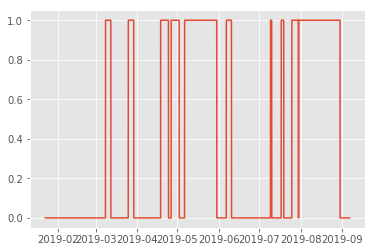

In [25]:
import pandas as pd
import numpy as np

buy = (bias < lb)  # 超跌
sell = (bias > ub)  # 超賣

hold = pd.Series(np.nan, index=sell.index)
hold[buy] = 1
hold[sell] = 0

hold = hold.ffill()

print(hold)
plt.plot(hold[4000:])
# ffill向下填充 1 nan nan 0 nan nan 1 ... -> ffill後 -> 1 1 1 0 0 1 ...
# bfill向上填充 --> 反向

#### 報酬率

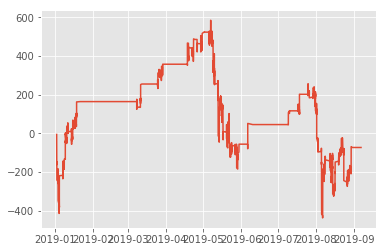

In [31]:
returns = twii.shift(-2) - twii.shift(-1)
returns[hold == 0] = 0  # 沒有持有，大盤漲跌與我們無關
# returns -= hold.diff().abs() * 3
# 累積報酬率
plt.plot(returns.cumsum())

In [44]:
twii.shift(-2)

date
2019-01-02 09:00:00     9731.54
2019-01-02 09:01:00     9727.67
2019-01-02 09:02:00     9729.62
2019-01-02 09:03:00     9727.42
2019-01-02 09:04:00     9726.03
2019-01-02 09:05:00     9718.20
2019-01-02 09:06:00     9717.73
2019-01-02 09:07:00     9716.43
2019-01-02 09:08:00     9723.24
2019-01-02 09:09:00     9719.07
2019-01-02 09:10:00     9726.21
2019-01-02 09:11:00     9720.68
2019-01-02 09:12:00     9720.98
2019-01-02 09:13:00     9722.89
2019-01-02 09:14:00     9718.30
2019-01-02 09:15:00     9714.23
2019-01-02 09:16:00     9715.75
2019-01-02 09:17:00     9713.96
2019-01-02 09:18:00     9713.77
2019-01-02 09:19:00     9713.09
2019-01-02 09:20:00     9712.18
2019-01-02 09:21:00     9713.41
2019-01-02 09:22:00     9712.86
2019-01-02 09:23:00     9715.19
2019-01-02 09:24:00     9714.08
2019-01-02 09:25:00     9715.30
2019-01-02 09:26:00     9713.99
2019-01-02 09:27:00     9716.67
2019-01-02 09:28:00     9714.62
2019-01-02 09:29:00     9714.81
                         ...   
201

502.3700000000008

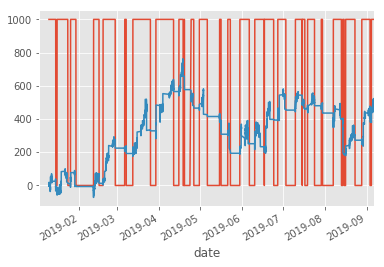

In [46]:
import numpy as np
import pandas as pd
%matplotlib inline

def strategy(m1=500, m2=1000, m3=1, m4=1, draw_plot=False):
    
    
    sma = twii.rolling(m1).mean()

    bias = (twii / sma)
    ub = 1 + bias.rolling(m2).std() * m3
    lb = 1 - bias.rolling(m2).std() * m4
    
    buy = (bias < lb) 
    sell = (bias > ub)

    hold = pd.Series(np.nan, index=sell.index)
    hold[buy] = 0
    hold[sell] = 1
    hold = hold.ffill()
    hold = hold.shift(1)  # 慢了一分鐘賣出
    
    # shift配負號就是往前推 -> 未來n筆
    # 報酬就是未來1分鐘股價 - 當下股價
    # 因為當下買的時候，不是立即送出，所以要再延遲一分鐘，考慮買的時候的時間差
    returns = twii.shift(-2) - twii.shift(-1)
    # 滑價: 當今天在交易時，買價跟回測的數值不一樣
    # 例如模擬買入是3塊錢，正式是買入卻是六塊錢 --> 滑3元
    
    
    returns[hold == 0] = 0
    returns -= hold.diff().abs() * 3 ## 從0變1或1變0，這邊的意義是 --> 手續費
    # 累積報酬
    creturn = returns.cumsum()
    
    if draw_plot:
        (hold*1000).plot()
        creturn.plot()
    
    return creturn.dropna()[-1]  # 累積報酬的最後一筆

    
strategy(draw_plot=True)

## 乖離率優化

In [41]:
vmax = 0
for m1 in range(500, 2000, 200):
    for m2 in range(400, 800, 20):
        v = strategy(m1, m2, 1, 1)
        if v > vmax:
            vmax = v
            print(vmax, m1, m2, 1, 1)

766.2399999999998 500 400 1 1
835.9599999999991 500 420 1 1
851.3899999999976 500 640 1 1
889.2899999999954 500 660 1 1
892.6000000000004 500 720 1 1
920.8499999999967 700 680 1 1
1054.5799999999963 900 400 1 1
1074.1699999999946 900 420 1 1


## 繪製出歷史報酬

1074.1699999999946

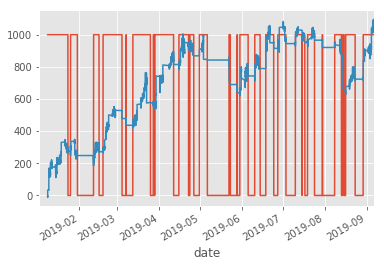

In [42]:
strategy(900, 420, 1, 1, draw_plot=True)